## Connect Google Drive
Our dataset has already been uploaded to the Google Drive servers. The codeblock that follows mounts drive filesystem as a partition into Google Colab. We use `Google Colab SDK` for the same.

In [ ]:
from google.colab import drive

DRIVE_DIR = '/content/drive'
drive.mount(DRIVE_DIR)
DRIVE_DIR = os.path.join(DRIVE_DIR, 'MyDrive')

In [ ]:
DRIVE_DIR = '/home/aniket/Projects/tf_model'

## Libraries Used
Throughout this notebook, we have used various libraries to study and analyze the outcome of our model. The list below presents these libraries, in no particular order of importance.
- `tensorflow`
- `matplotlib`
- Built-in libraries like `os`, `random`, etc.

It should be noted that these two packages use `numpy`, `scipy`, `google-auth`, `pandas`, etc. internally (and implicitly).

In [ ]:
import tensorflow as tf

## Mark Important Directories
Throughout the code, we will extensively refer to some directories. To make the code easier to maintain (and port), we will use variables to refer to these directories.
- `base_dir` - The "root" of our training and validation dataset.
- `train_dir` - Training images, categorised by directories, are in this directory.
- `validation_dir` - Same directories as the training folder, with fewer images.

`train_dir` contains a large number of images to train on, whereas `validation_dir` has different images belonging to the same classes to check the accuracy of the model.


In [ ]:
# mark important directories
import os

base_dir = os.path.join(DRIVE_DIR, 'dataset')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

num_classes: int = len(os.listdir(train_dir))

Let's take a look at the contents of these "special" directories.

We will look at the first five entries in each directory.

In [ ]:
# peek into directories - see the first 5 items
from pprint import pprint

print('Base Directory Contents:')
pprint(os.listdir(base_dir))
print('\nTrain Directory Contents:')
pprint(os.listdir(train_dir)[:5])
print('\nValid Directory Contents:')
pprint(os.listdir(validation_dir)[:5])
print()

Base Directory Contents:
['prediction', 'prediction_model', 'valid', 'train']

Train Directory Contents:
['Tomato___Spider_mites Two-spotted_spider_mite',
 'Peach___Bacterial_spot',
 'Grape___healthy',
 'Tomato___Septoria_leaf_spot',
 'Squash___Powdery_mildew']

Valid Directory Contents:
['Tomato___Spider_mites Two-spotted_spider_mite',
 'Peach___Bacterial_spot',
 'Grape___healthy',
 'Tomato___Septoria_leaf_spot',
 'Squash___Powdery_mildew']



## Understanding our Data

Let's take a more analytical look at these directories, we will look at the total images, broken down by the number of images for each class. Henceforth, this process will be simply referred to as "analysing" the directory.

In [ ]:
# find the number of images in each class

def analyse_dir(dpath, line_len=60):
  total_imgs = 0
  walker = os.walk(dpath)
  next(walker)  # skip '.' directory
  for dirpath, dirnames, filenames in walker:
    num_files = len(filenames)
    total_imgs += num_files
    print(f'{os.path.basename(dirpath).ljust(line_len)} : {num_files} images')
  label = f"Total images in '{os.path.basename(dpath)}' directory".ljust(line_len)
  print(f'{label} : {total_imgs} images')

Analysing `train_dir`:

In [ ]:
analyse_dir(train_dir)

Tomato___Spider_mites Two-spotted_spider_mite                : 1741 images
Peach___Bacterial_spot                                       : 1838 images
Grape___healthy                                              : 1692 images
Tomato___Septoria_leaf_spot                                  : 1745 images
Squash___Powdery_mildew                                      : 1736 images
Strawberry___healthy                                         : 1824 images
Tomato___healthy                                             : 1926 images
Corn_(maize)___healthy                                       : 1859 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           : 1642 images
Potato___Late_blight                                         : 1939 images
Strawberry___Leaf_scorch                                     : 1774 images
Cherry_(including_sour)___healthy                            : 1826 images
Grape___Black_rot                                            : 1888 images
Tomato___Late_blight     

Analysing `validation_dir`:

In [ ]:
analyse_dir(validation_dir)

Tomato___Spider_mites Two-spotted_spider_mite                : 435 images
Peach___Bacterial_spot                                       : 459 images
Grape___healthy                                              : 423 images
Tomato___Septoria_leaf_spot                                  : 436 images
Squash___Powdery_mildew                                      : 434 images
Strawberry___healthy                                         : 456 images
Tomato___healthy                                             : 481 images
Corn_(maize)___healthy                                       : 465 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           : 410 images
Potato___Late_blight                                         : 485 images
Strawberry___Leaf_scorch                                     : 444 images
Cherry_(including_sour)___healthy                            : 456 images
Grape___Black_rot                                            : 472 images
Tomato___Late_blight                  

## Cherry Pick our Data
Cherry picking refers to carefully selecting certain items out of a collection. Here, we uniformly select images from our dataset, across all classes to display as a grid.

In [ ]:
# cherry pick some images for demonstration

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# grid for image output
N_ROWS = 4
N_COLS = 4

img_paths = []
for dirname, dirnames, filenames in os.walk(train_dir):
  img_paths += [os.path.join(os.path.abspath(dirname), fname)
                for fname in filenames]

If the cell below is rerun again, it will refresh will newly selected images and regenerate the grid of samples.

We use `matplotlib` for this purpose.

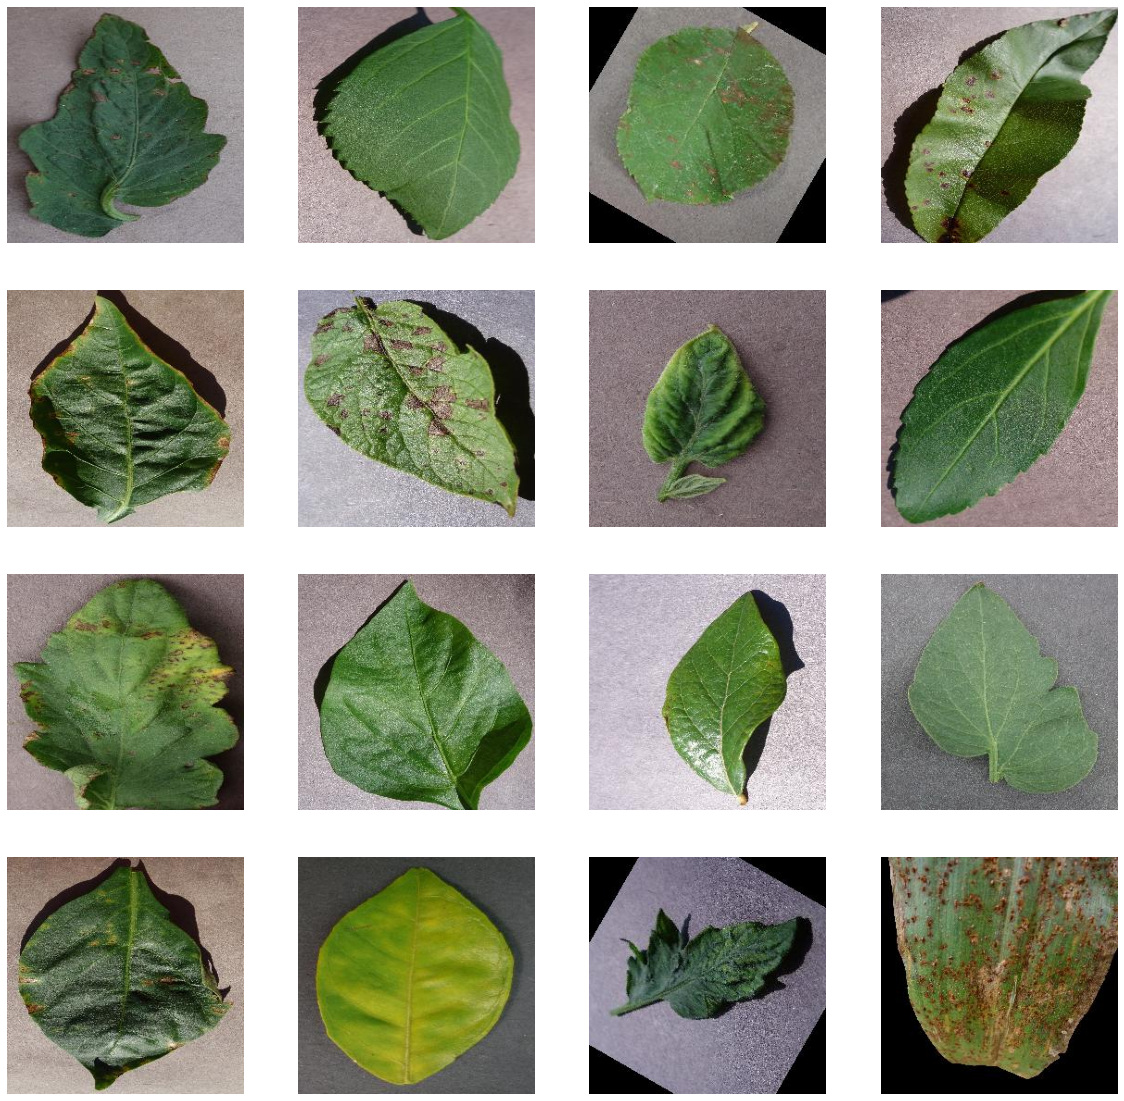

In [ ]:
# show the grid, run multiple times to see different images

import random

fig = plt.gcf()
# assume images are 5" x 5"
fig.set_size_inches(N_COLS * 5, N_ROWS * 5)

for i, img_path in enumerate(random.choices(img_paths, k=N_ROWS*N_COLS),
                             start=1):
  sp = plt.subplot(N_ROWS, N_COLS, i)
  sp.axis('OFF')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Define the Model
The model is the "heart and soul" of any neural network project. The codeblock below defines the structure of these interconnected layers of "neurons".
The broad categories are explained below:
- **Convolutional Layer**

    These layers apply varous convolutions or transformations to the given image in order to highlight (or suppress) very specific features. Combining these basic, but specific features allow us to trace curves, edges and patterns.

- **Pooling Layer**

    Pooling is the term given to "combination of basic features into more complex ones". Max Pooling is a variant of pooling that highlights features that the convolutions have given the most value to and suppresses the rest.

- **Flattening**

    Flattening is the process of converting an *n-dimensional* grid of data points into a single dimension data array by means of concatenation and joining.

- **Dense Layer**

    Dense networks are the decision makers of these artificial neural networks. In a dense layer, every neuron is connected to every other neuron of the next layer. This opens up a large, large varierty of parameters and biases to adjust for the model. Dense layers require huge amounts of data.

In [ ]:
# define the model
IMAGE_SHAPE = (256, 256)

model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(*IMAGE_SHAPE, 3)),

  # CNN and pooling
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  # flatten and DNN
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 64)      

## Compiling the Model
To compile a model in tensorflow, we define the optimizer to use, the loss function as well as the metrics that we would like to track.

Here, we use the **adam** optimizer function. Adam is an optimization solver that is computationally efficient, requires little memory, and is well suited for problems that are large in terms of data or parameters or both. Adam is a popular extension to *stochastic gradient descent (SGD)*.

We also utilise **categorical_crossentropy** as the loss function. A loss function is used to calculate "how wrong the model was"

In [ ]:
# compile the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Image Preprocessing (Augmentation)
Images somtimes need to be augmented, and throughout the process of training the model multiple times, augmentation may be modified, enabled or completely turned off.

We have used tensorflow's `ImageDataGenerator` for this purpose. It supports a wide variety of configuration options. To show the full range of operations, some code has been commented out.

In the code below, the datagen objects use the `flow_from_directory()` method to read images from the classes defined above.

In [ ]:
# data preprocessing (augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_options = {
    'rescale': 1/255,
    # 'rotation_range': 40,
    # 'horizontal_flip': True,
    # 'width_shift_range': 0.2,
    # 'height_shift_range': 0.2,
    # 'shear_range': 0.2,
    # 'zoom_range': 0.2,
    # 'fill_mode': 'nearest'
}

generator_options = {
    'shuffle': True,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'batch_size': 20,
    'target_size': IMAGE_SHAPE
}

train_datagen = ImageDataGenerator(**datagen_options)
validation_datagen = ImageDataGenerator(**datagen_options)

train_generator = train_datagen.flow_from_directory(
    train_dir, **generator_options)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, **{**generator_options, 'shuffle': False})

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# train the model
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/15
100/100 [==============================] - 166s 2s/step - loss: 3.6527 - accuracy: 0.0570 - val_loss: 2.6126 - val_accuracy: 0.3030
Epoch 2/15
100/100 [==============================] - 162s 2s/step - loss: 2.9331 - accuracy: 0.2080 - val_loss: 2.5594 - val_accuracy: 0.2410
Epoch 3/15
100/100 [==============================] - 158s 2s/step - loss: 2.1932 - accuracy: 0.3660 - val_loss: 2.5205 - val_accuracy: 0.2690
Epoch 4/15
100/100 [==============================] - 155s 2s/step - loss: 1.6790 - accuracy: 0.5045 - val_loss: 1.1037 - val_accuracy: 0.6760
Epoch 5/15
100/100 [==============================] - 156s 2s/step - loss: 1.3759 - accuracy: 0.5940 - val_loss: 1.5651 - val_accuracy: 0.5410
Epoch 6/15
100/100 [==============================] - 162s 2s/step - loss: 1.3185 - accuracy: 0.5980 - val_loss: 1.9215 - val_accuracy: 0.4430
Epoch 7/15
100/100 [==============================] - 143s 1s/step - loss: 1.0927 - accuracy: 0.6730 - val_loss: 1.7230 - val_accuracy: 0.5060

## Saving and Loading the Model
Models in tensorflow have "state" associated with them, that is the architecture, the weights and biases. These values can be written to a file for later use. THe former operation is called "saving" the model, while the later is called "loading" it.

In [ ]:
# model 'v1': image dimensions not adjusted properly
# model 'v2': epochs too low
# model 'v3': Conv2D architecture can be optimised
# model 'v4': Image dimentions canged since color channel added
# model 'v5': Current Model - ~80% accuracy (average)
model.save(os.path.join(base_dir, 'models', 'v5'))

INFO:tensorflow:Assets written to: /home/aniket/Projects/tf_model/dataset/models/v5/assets


In [ ]:
# load a model (saves time)
model = tf.keras.models.load_model(os.path.join(base_dir, 'models', 'v5'))

## Prediction
The real test of an NN model is when newer data is passed to it. The model has never seen this data before and will try to  predict the output based on what is has learnt in "training".

`sample_imgs` below contains the absolute paths to all prediction images.

In [ ]:
# using the model to produce predictions
prediction_dir = os.path.join(base_dir, 'prediction')
sample_imgs = [os.path.join(prediction_dir, img_path)
               for img_path in os.listdir(prediction_dir)]

In [ ]:
import numpy as np

classes = []
walker = os.walk(validation_dir)
next(walker)
for dirname, dirnames, filenames in walker:
  classes.append(dirname)

def predict(img, img_path):
  prediction = model.predict(np.expand_dims(img, axis=0))
  print(f'Actual    : {os.path.basename(img_path)}')
  print(f'Prediction: {classes[np.argmax(prediction)]}')


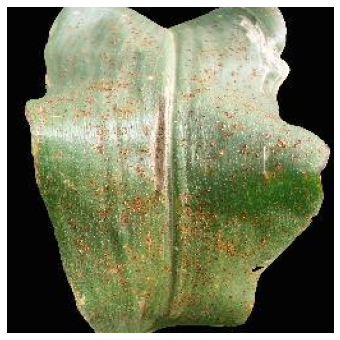

Actual    : CornCommonRust2.JPG
Prediction: /home/aniket/Projects/tf_model/dataset/valid/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


In [ ]:
# choose a random image and check the prediction
IMAGE_SIZE_INCHES = (6, 6)  # (height, width)
img_path = random.choice(sample_imgs)

fig = plt.gcf()
fig.set_size_inches(*IMAGE_SIZE_INCHES)
img = mpimg.imread(img_path)
plt.axis('OFF')
plt.imshow(img)
plt.show()

predict(img, img_path)

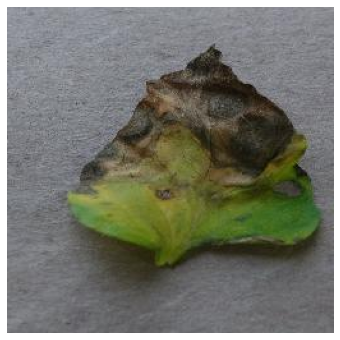

Actual    : TomatoEarlyBlight2.JPG
Prediction: /home/aniket/Projects/tf_model/dataset/valid/Tomato___Early_blight


In [ ]:
img_path = random.choice(sample_imgs)

fig = plt.gcf()
fig.set_size_inches(*IMAGE_SIZE_INCHES)
img = mpimg.imread(img_path)
plt.axis('OFF')
plt.imshow(img)
plt.show()

predict(img, img_path)